# Multimodal RAG Tutorial using GPT-4 and LlamaIndex

## Table of Contents
1. Introduction to Multimodal RAG
2. Setup and Installation
3. Preparing the Environment
4. Data Collection and Preparation
5. Building the Multimodal Index
6. Implementing Multimodal Retrieval
8. Multimodal RAG Querying


## 1. Introduction to Multimodal RAG

Multimodal Retrieval-Augmented Generation (RAG) is an advanced technique that combines text and image data to enhance the capabilities of large language models (LLMs) like GPT-4. This tutorial will guide you through the process of implementing a multimodal RAG system using GPT-4 and LlamaIndex.

### How Multimodal RAG Works

Multimodal RAG extends traditional text-based RAG by incorporating image data:

1. **Indexing**: Both text and images are processed and stored in separate vector stores.
2. **Retrieval**: When a query is received, relevant text and images are retrieved based on similarity.
3. **Augmentation**: The retrieved information is used to augment the input to the LLM.
4. **Generation**: The LLM generates a response based on the augmented input.


## 2. Setup and Installation
First, we need to install the required dependencies. We'll use a virtual environment to keep our project isolated.


In [1]:
%pip install llama-index-embeddings-clip

You should consider upgrading via the '/Users/taurangela/Desktop/Github/Multimodal-RAG/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Create a virtual environment
# python -m venv multimodal_rag_env

# Activate the virtual environment
# On Windows:
# multimodal_rag_env\Scripts\activate
# On macOS and Linux:
# source multimodal_rag_env/bin/activate

# Install required packages
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-vector-stores-qdrant
%pip install llama_index ftfy regex tqdm
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client
%pip install gdown

You should consider upgrading via the '/Users/taurangela/Desktop/Github/Multimodal-RAG/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/taurangela/Desktop/Github/Multimodal-RAG/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/taurangela/Desktop/Github/Multimodal-RAG/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/taurangela/Desktop/Github/Multimodal-RAG/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/taurangela/Desktop/Github/Multimodal-RAG/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart t

## 3. Preparing the Environment
Now, let's set up our Python environment and configure the OpenAI API key.

In [5]:
import os
import requests
import matplotlib.pyplot as plt
from PIL import Image
from dotenv import load_dotenv
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Payload indexes have no effect in the local Qdrant.")

# Load environment variables from a .env file
load_dotenv()

# Get your Groq API key from environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Ensure the API key is set correctly
if OPENAI_API_KEY is None:
    raise ValueError("OPENAI API key not found. Set it in the environment variables or in a .env file.")

In [6]:
from pathlib import Path

# Create necessary directories
input_image_path = Path("../Data/input_images")
data_path = Path("../Data/mixed_wiki")

# Create the parent directory and subdirectories if they don't exist
for path in [input_image_path, data_path]:
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)

print("Environment prepared successfully!")


Environment prepared successfully!


#### Example Images

In [7]:
import gdown

# Define the URLs and output paths
files = {
    "long_range_spec.png": "1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj",
    "model_y.png": "19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ",
    "performance_spec.png": "1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF",
    "price.png": "1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i",
    "real_wheel_spec.png": "1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV"
}

# Download each file
for filename, file_id in files.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = f"../Data/input_images/{filename}"
    gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj
To: /Users/taurangela/Desktop/Github/Multimodal-RAG/Data/input_images/long_range_spec.png
100%|██████████| 161k/161k [00:00<00:00, 4.30MB/s]
Downloading...
From: https://drive.google.com/uc?id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ
To: /Users/taurangela/Desktop/Github/Multimodal-RAG/Data/input_images/model_y.png
100%|██████████| 1.31M/1.31M [00:00<00:00, 3.81MB/s]
Downloading...
From: https://drive.google.com/uc?id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF
To: /Users/taurangela/Desktop/Github/Multimodal-RAG/Data/input_images/performance_spec.png
100%|██████████| 62.8k/62.8k [00:00<00:00, 944kB/s]
Downloading...
From: https://drive.google.com/uc?id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i
To: /Users/taurangela/Desktop/Github/Multimodal-RAG/Data/input_images/price.png
100%|██████████| 129k/129k [00:00<00:00, 869kB/s]
Downloading...
From: https://drive.google.com/uc?id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV
To: /Users/taurangela

#### Let's look at the images

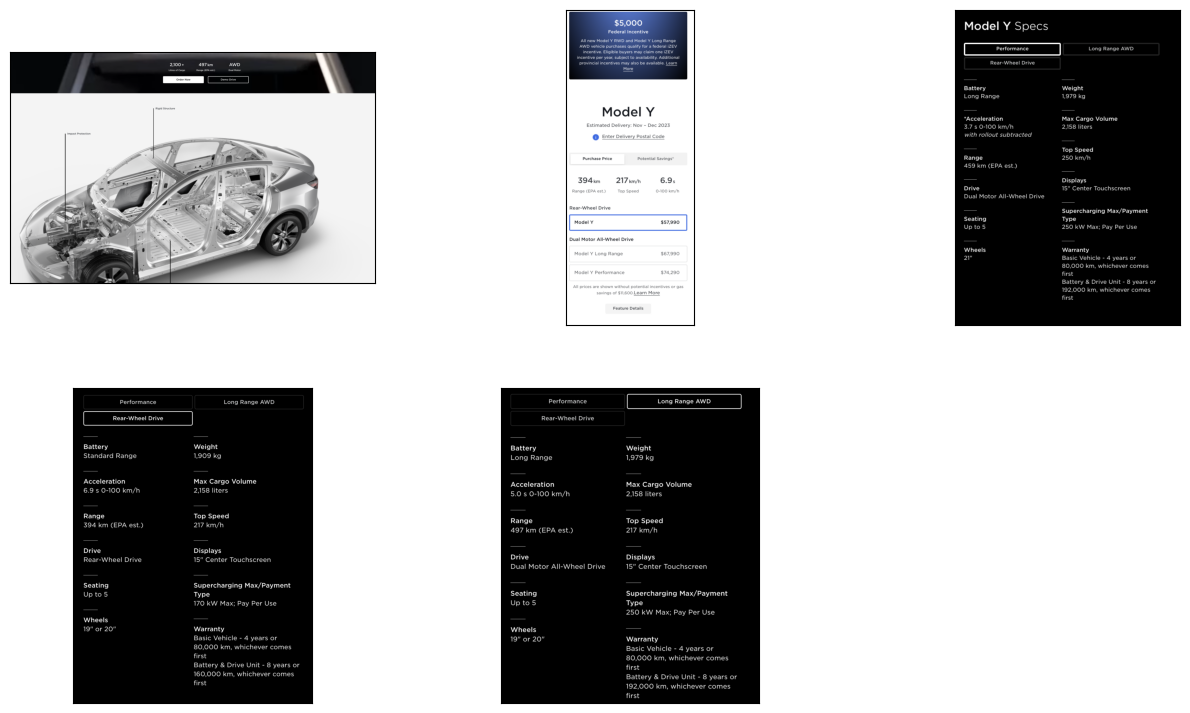

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("../Data/input_images"):
    image_paths.append(str(os.path.join("../Data/input_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

### Genereate text descriptions for images using GPT-4o

In [9]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader("../Data/input_images").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Generate detailed text description for each image.",
    image_documents=image_documents,
)

print(response_1)

### Image 1: Specifications for Long Range AWD Model

- **Performance Options**: Performance, Rear-Wheel Drive, Long Range AWD
- **Battery**: Long Range
- **Weight**: 1,979 kg
- **Acceleration**: 5.0 s 0-100 km/h
- **Max Cargo Volume**: 2,158 liters
- **Range**: 497 km (EPA est.)
- **Top Speed**: 217 km/h
- **Drive**: Dual Motor All-Wheel Drive
- **Displays**: 15" Center Touchscreen
- **Seating**: Up to 5
- **Supercharging Max/Payment Type**: 250 kW Max; Pay Per Use
- **Wheels**: 19" or 20"
- **Warranty**:
  - Basic Vehicle: 4 years or 80,000 km, whichever comes first
  - Battery & Drive Unit: 8 years or 192,000 km, whichever comes first

### Image 2: Structural Diagram of the Vehicle

- **Labels**:
  - **Rigid Structure**: Indicates the robust framework of the vehicle.
  - **Impact Protection**: Highlights the areas designed to absorb and mitigate impact during collisions.

### Image 3: Specifications for Model Y

- **Model Y Specs**: Performance, Long Range AWD, Rear-Wheel Drive
- **

## 4. Data Collection and Preparation
In this section, we'll collect text and image data from Wikipedia and other sources.

In [10]:
def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith((".jpg", ".png")):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls


In [11]:
# List of Wikipedia titles to fetch
wiki_titles = {
    "Tesla Model Y",
    "Tesla Model X",
    "Tesla Model 3",
    "Tesla Model S",
    "Kia EV6",
    "BMW i3",
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
    "Rivian",
    "Polestar",
}


In [12]:
import requests
import os

# Define constants
image_uuid = 0
MAX_IMAGES_PER_WIKI = 5

# Create the data_path directory if it doesn't exist
os.makedirs(data_path, exist_ok=True)

for title in wiki_titles:
    # Fetch text
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    # Fetch images
    images_per_wiki = 0
    list_img_urls = get_wikipedia_images(title)

    for url in list_img_urls:
        if url.endswith((".jpg", ".png", ".svg")):
            image_uuid += 1
            response = requests.get(url)
            if response.status_code == 200:
                with open(data_path / f"{image_uuid}.jpg", "wb") as fp:
                    fp.write(response.content)
                images_per_wiki += 1
                if images_per_wiki >= MAX_IMAGES_PER_WIKI:
                    break

print("Data collection completed!")

Data collection completed!


In [13]:
!curl -L "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -o ./mixed_wiki/tesla_2021_10k.htm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17  100    17    0     0     12      0  0:00:01  0:00:01 --:--:--    12
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0Warning: Failed to open the file ./mixed_wiki/tesla_2021_10k.htm: No such file 
  0 7713k    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
curl: (56) Failure writing output to destination, passed 15648 returned 4294967295


## 5. Building the Multimodal Index
Now that we have our data, let's build the multimodal index using LlamaIndex and Qdrant as our vector store.

In [21]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext
import qdrant_client
import ssl
import os

# Configure SSL context properly
ssl_context = ssl.create_default_context()
ssl_context.check_hostname = True
ssl_context.verify_mode = ssl.CERT_REQUIRED

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path=os.path.abspath("../Vector-Store/qdrant_mm_db"))

text_store = QdrantVectorStore(client=client, collection_name="text_collection")
image_store = QdrantVectorStore(client=client, collection_name="image_collection")

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader(os.path.abspath("../Data/mixed_wiki/")).load_data()

# Initialize the index
try:
    index = MultiModalVectorStoreIndex.from_documents(
        documents,
        storage_context=storage_context,
    )
    print("Multimodal index built successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

Multimodal index built successfully!


## 6. Implementing Multimodal Retrieval
Let's create a retriever engine that can fetch both text and images based on a query.

In [17]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

MAX_TOKENS = 50
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)

def retrieve_and_display(query):
    retrieval_results = retriever_engine.retrieve(query[:MAX_TOKENS])

    retrieved_images = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_images.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)

    if retrieved_images:
        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(retrieved_images):
            plt.subplot(1, len(retrieved_images), i+1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

# Example usage
# retrieve_and_display("Tell me about electric cars")

**Node ID:** bb127638-c377-4119-a4f5-ded483485911<br>**Similarity:** 0.8341639707256195<br>**Text:** The Tesla Model S is a battery-electric, four-door full-size car that has been produced by the American automaker Tesla since 2012. The automaker's longest-produced model and second vehicle, critic...<br>

**Node ID:** de80eaff-5149-46b8-b91c-f5226acd5af6<br>**Similarity:** 0.8318873078428131<br>**Text:** == Reception and legacy ==

The Model S has been recognized as an influential electric car. In a 2014 review for the newspaper The Sunday Times, Nick Rufford remarked, "the Model S represents the l...<br>

**Node ID:** 542edb20-2039-4b2c-9128-0502bf6ea8ab<br>**Similarity:** 0.827031161295267<br>**Text:** The Tesla Model X is a battery electric mid-size luxury crossover SUV built by Tesla, Inc. since 2015. Developed from the full-sized sedan platform of the Tesla Model S, the vehicle notably uses fa...<br>

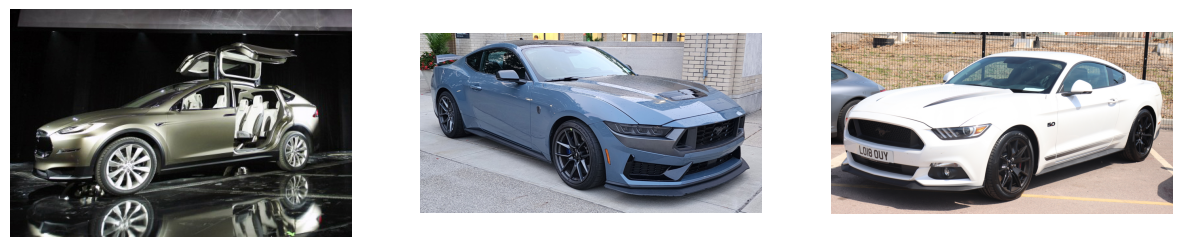

In [18]:
retrieve_and_display("What is the best electric Sedan?")

## 7. Multimodal RAG Querying
Finally, let's implement a multimodal RAG query engine that can answer questions using both text and image data.

Answer: Based on the provided context, there is no information about the design features of the Tesla Model S. The context only provides detailed information about various Rivian models, including the R1T, R1S, R2, R3, and the Electric Delivery Van (EDV).

To compare the design features of the Tesla Model S and Rivian R1, additional information about the Tesla Model S would be required. The context only allows for a detailed description of the Rivian models, particularly the R1T and R1S, which share a common electric chassis and have specific design features related to their electric vehicle architecture.

Sources:


**Node ID:** e7cb1759-ce24-4474-93f4-1798ff05e7f0<br>**Similarity:** 0.8589685366122161<br>**Text:** === R1S ===

The R1S is a sport utility vehicle version of the first Rivian platform. Because of a shared electric chassis, the R1S design aimed, as of 2018, to have 91 percent shared components wi...<br>

**Node ID:** ec0e8297-703f-402c-a3b1-c49cab7d57f2<br>**Similarity:** 0.8549789281434864<br>**Text:** === R1T ===

The R1T is a pickup truck, which features four electric motors, two located on each axle (front and rear). The front two motors produce 415 hp (309 kW) and 413 lb⋅ft (560 N⋅m) of torqu...<br>

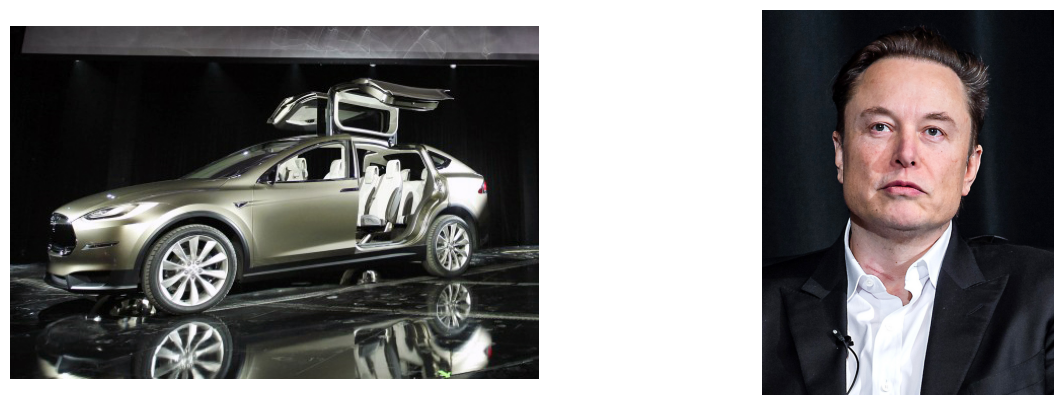

In [19]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

def multimodal_rag_query(query_str):
    response = query_engine.query(query_str)
    print("Answer:", str(response))

    print("\nSources:")
    for text_node in response.metadata["text_nodes"]:
        display_source_node(text_node, source_length=200)

    if response.metadata["image_nodes"]:
        plt.figure(figsize=(15, 5))
        for i, img_node in enumerate(response.metadata["image_nodes"]):
            plt.subplot(1, len(response.metadata["image_nodes"]), i+1)
            img = Image.open(img_node.metadata["file_path"])
            plt.imshow(img)
            plt.axis('off')
        plt.show()

# Example usage
multimodal_rag_query("Compare the design features of Tesla Model S and Rivian R1")